<a href="https://colab.research.google.com/github/travislatchman/TheHearts/blob/main/HeartSoundClassifier_CNN_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import librosa
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.signal import butter, lfilter
import scipy.io
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

seed = 1
np.random.seed(seed)
rng = np.random.default_rng(seed) # seeded random number generator

In [ ]:
# # Define the CNN model
# class HeartSoundClassifier(nn.Module):
#     def __init__(self):
#         super(HeartSoundClassifier, self).__init__()
#         self.conv1 = nn.Conv1d(1, 32, kernel_size=5)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool1d(2)
#         self.conv2 = nn.Conv1d(32, 64, kernel_size=5)
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(64 * ((X_train.shape[1] - 4) // 2 - 4) // 2, 128)
#         self.dropout = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(128, 4)  # Assuming 4 classes

#     def forward(self, x):
#         x = self.maxpool(self.relu(self.conv1(x)))
#         x = self.maxpool(self.relu(self.conv2(x)))
#         x = self.flatten(x)
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x



In [ ]:
# # Instantiate the model
# model = HeartSoundClassifier()

# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# X_val, y_val = X_val.to(device), y_val.to(device)

# # Define loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters())

In [ ]:
# # Train the model
# num_epochs = 20

# for epoch in range(num_epochs):
#     model.train()
#     for inputs, targets in train_loader:
#         inputs, targets = inputs.to(device), targets.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()

#     # Validate the model
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, targets in val_loader:
#             inputs, targets = inputs.to(device), targets.to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += targets.size(0)
#             correct += (predicted == targets).sum().item()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Validation accuracy: {100 * correct / total:.2f}%')


In [ ]:
# # Final evaluation
# model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for inputs, targets in val_loader:
#         inputs, targets = inputs.to(device), targets.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         total += targets.size(0)
#         correct += (predicted == targets).sum().item()

# print(f'Final validation accuracy: {100 * correct / total:.2f}%')


### Preprocessing functions

In [ ]:
# Preprocessing functions
def load_audio_file(file_path):
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    if (sample_rate - 2000)**2 > 100:
      print(f"{sample_rate}, resampled")
      audio_data, sample_rate = librosa.load(file_path, sr=2000)
      # print("resampled")
    return audio_data, sample_rate

In [ ]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [ ]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
def apply_lowpass_filter(audio_data, sample_rate, cutoff=195):
    filtered_data = butter_lowpass_filter(audio_data, cutoff, sample_rate)
    return filtered_data

In [ ]:
def perform_fft(filtered_data):
    fft_data = np.fft.fft(filtered_data)
    return fft_data

### Data Augmentation (REVIEW)


##### Time Shifting - shift the audio signal by a random amount

In [ ]:
def time_shift(audio_data, sample_rate):
    shift_amount = int(sample_rate * np.random.uniform(-0.1, 0.1))
    shifted_data = np.roll(audio_data, shift_amount)
    return shifted_data

##### Pitch Shifting - Change the pitch of the audio signal by a random factor

In [ ]:
def pitch_shift(audio_data, sample_rate):
    pitch_shift_amount = np.random.uniform(-1.0, 1.0)
    shifted_data = librosa.effects.pitch_shift(audio_data, sample_rate, pitch_shift_amount)
    return shifted_data

##### Add Random Noise

In [ ]:
def add_noise(audio_data):
    noise_level = np.random.uniform(0.005, 0.05)
    noise = np.random.randn(len(audio_data)) * noise_level
    noisy_data = audio_data + noise # add noise ~ normal(mean=0, std=noise_level)
    return noisy_data

### New Dataset if you want to augment the data - adds parameter  (REVIEW)

In [ ]:
class HeartSoundDataset(Dataset):
    def __init__(self, file_paths, labels, num_output_samples, transform=None, augmentation=False):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.num_output_samples = num_output_samples
        self.augmentation = augmentation

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        audio_data, sample_rate = load_audio_file(file_path)

        # Apply data augmentation techniques if the augmentation parameter is set to True
        if self.augmentation:
            audio_data = time_shift(audio_data, sample_rate)
            audio_data = pitch_shift(audio_data, sample_rate)
            audio_data = add_noise(audio_data)

        filtered_data = apply_lowpass_filter(audio_data, sample_rate)
        fft_data = perform_fft(filtered_data)

        # Use only the real part of the FFT data
        real_fft_data = np.real(fft_data)

        # Normalize data
        normalized_data = (real_fft_data - np.min(real_fft_data)) / (np.max(real_fft_data) - np.min(real_fft_data))

        if self.transform:
            normalized_data = self.transform(normalized_data)

        label = self.labels[idx]
        return torch.tensor(normalized_data[:self.num_output_samples]).float(), label



### New Dataloaders for Augmentation - added parameter is set to true (REVIEW)

In [ ]:
def create_dataloaders(file_paths, labels, max_num_samples, rng, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, batch_size=100, augmentation=True):
    dataset_size = len(file_paths)
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    dataset = HeartSoundDataset(file_paths, labels, max_num_samples)
    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size]) #, generator=rng)

    # Apply data augmentation only to the training dataset
    train_set.dataset = HeartSoundDataset(train_set.dataset.file_paths, train_set.dataset.labels, train_set.dataset.num_output_samples, augmentation=augmentation)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


### Building Dataset

In [ ]:
class HeartSoundDataset(Dataset):
  def __init__(self, file_paths, labels, num_output_samples, transform=None):
    self.file_paths = file_paths
    self.labels = labels
    self.transform = transform
    self.num_output_samples = num_output_samples

  def __len__(self):
    return len(self.file_paths)

  def __getitem__(self, idx):
    file_path = self.file_paths[idx]
    audio_data, sample_rate = load_audio_file(file_path)
    filtered_data = apply_lowpass_filter(audio_data, sample_rate)
    fft_data = perform_fft(filtered_data)

    # Use only the real part of the FFT data
    real_fft_data = np.real(fft_data)

    # Normalize data
    normalized_data = (real_fft_data - np.min(real_fft_data)) / (np.max(real_fft_data) - np.min(real_fft_data))

    if self.transform:
      normalized_data = self.transform(normalized_data)

    label = self.labels[idx]
    return torch.tensor(normalized_data[:self.num_output_samples]).float(), label



In [ ]:
def create_dataloaders(file_paths, labels, max_num_samples, rng, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, batch_size=100):
  dataset_size = len(file_paths)
  train_size = int(train_ratio * dataset_size)
  val_size = int(val_ratio * dataset_size)
  test_size = dataset_size - train_size - val_size

  dataset = HeartSoundDataset(file_paths, labels, max_num_samples)
  train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size],)# generator = rng)

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

### Heart Sound Classifier

In [ ]:
class HeartSoundClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HeartSoundClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=15, stride=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(8)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=15, stride=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(8)
        self.flatten = nn.Flatten()
        # self.fc1 = nn.Linear(input_size // 4 * 16, 32)
        self.fc1 = nn.Linear(960, 32)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(32, num_classes)
        self.softmax = nn.Softmax(0)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)
        return self.softmax(x)


### Classifier with Dropout and Regularization (REVIEW)

In [ ]:
# class HeartSoundClassifier(nn.Module):
#     def __init__(self, input_size, num_classes):
#         super(HeartSoundClassifier, self).__init__()
#         self.conv1 = nn.Conv1d(1, 8, kernel_size=15, stride=1)
#         self.bn1 = nn.BatchNorm1d(8) # BATCH 
#         self.relu1 = nn.ReLU()
#         self.pool1 = nn.MaxPool1d(8)
#         self.dropout1 = nn.Dropout(0.5) # DROPOUT

#         self.conv2 = nn.Conv1d(8, 16, kernel_size=15, stride=1)
#         self.bn2 = nn.BatchNorm1d(16)
#         self.relu2 = nn.ReLU()
#         self.pool2 = nn.MaxPool1d(8)
#         self.dropout2 = nn.Dropout(0.5)

#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(960, 32)
#         self.relu3 = nn.ReLU()
#         self.dropout3 = nn.Dropout(0.5)

#         self.fc2 = nn.Linear(32, num_classes)
#         self.softmax = nn.Softmax(0)

#     def forward(self, x):
#         x = x.unsqueeze(1)
#         x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
#         x = self.dropout1(x)

#         x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
#         x = self.dropout2(x)

#         x = self.flatten(x)

#         x = self.relu3(self.fc1(x))
#         x = self.dropout3(x)

#         x = self.fc2(x)

#         return self.softmax(x)

In [ ]:
def write_prepped_audio(label_dir, file_name, audio_sample_len):
  if not os.path.exists(os.path.join(label_dir, "prepped_audio")):
    os.makedirs(os.path.join(label_dir, "prepped_audio"))
  new_file_path = os.path.join(label_dir, "prepped_audio", file_name)
  audio_data, sample_rate = load_audio_file(new_file_path)

  # if audio_data is shorter than 1/3 the target audio sample length, return None
  # else, pad with zeros
  if len(audio_data) < audio_sample_len/3:
    return None
  else:
    new_audio_data = np.zeros(audio_sample_len, dtype=np.float32)
    new_audio_data[:len(audio_data)] = audio_data
    scipy.io.wavfile.write(new_audio_data)

# Training, Validation, Testing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data and create data loaders
# data_dir = '/content/drive/MyDrive/MLMA Group/CardiacData/DatasetB'
data_dir = '/content/drive/MyDrive/MLMA Group/CardiacData/physionet cardiac sounds/heart_sound/train'
label_encoder = LabelEncoder()

file_paths = []
labels = []
audio_sample_len = 9000

for label in os.listdir(data_dir):
  label_dir = os.path.join(data_dir, label)
  for file_name in os.listdir(label_dir):
    if file_name[-4:] == ".wav" and len(load_audio_file(os.path.join(label_dir, file_name))[0]) > audio_sample_len:
      new_file_path = write_prepped_audio(label_dir, file_name, audio_sample_len)
      if new_file_path is not None:
        file_paths.append(new_file_path)
        labels.append(label)

encoded_labels = label_encoder.fit_transform(labels)
train_loader, val_loader, test_loader = create_dataloaders(file_paths, encoded_labels, audio_sample_len, rng)


(array([  0.,   0.,  20.,  26.,  26.,  31.,  28.,  18.,  19., 134.]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 30000.]),
 <BarContainer object of 10 artists>)

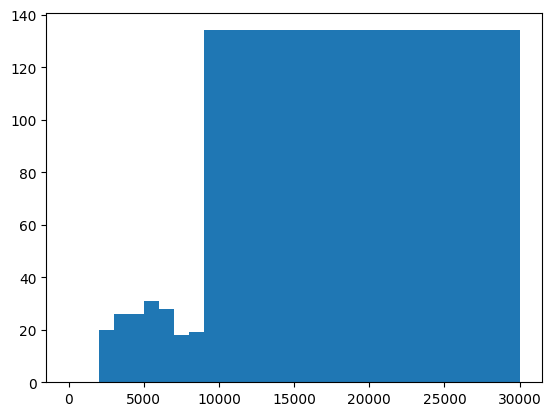

In [ ]:
file_lensB = np.zeros(len(file_paths))
for i, file_path in enumerate(file_paths):
  file_lensB[i] = len(load_audio_file(file_path)[0])

plt.hist(np.array(file_lensB)*0.5, bins=[0,1000,2000,3000,4000,5000,6000,7000,8000,9000,30000])

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3., 299.]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 50000.]),
 <BarContainer object of 10 artists>)

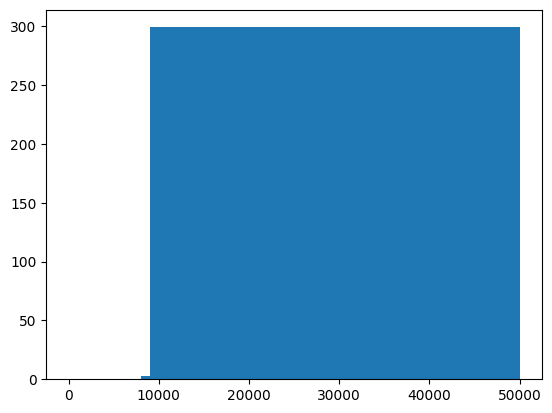

In [ ]:
plt.hist(file_lens[:i], bins=[0,1000,2000,3000,4000,5000,6000,7000,8000,9000,50000])

In [ ]:
# Initialize the model, loss function, and optimizer
input_size = len(train_loader.dataset[0][0])
num_classes = len(np.unique(encoded_labels))
model = HeartSoundClassifier(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

### Maybe add as a parameter for L1, L2 loss? (weight decay)

In [ ]:
# # Adjust this parameter for L1/L2 regularization
# weight_decay = 1e-5  
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

### Early Stopping (REVIEW) 

In [ ]:
# # Set early stopping parameters
# patience = 5
# min_delta = 0.001

# # Initialize variables to track best validation loss and epochs without improvement
# best_val_loss = float('inf')
# epochs_without_improvement = 0

# for epoch in range(num_epochs):
#     # Train the model
#     model.train()
#     train_loss = 0.0
#     correct = 0
#     total = 0
#     for batch_num, (data, labels) in enumerate(train_loader):
#         optimizer.zero_grad()
#         outputs = model(data)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     # Compute training accuracy and loss
#     train_acc = 100 * correct / total
#     train_loss /= len(train_loader)
#     train_accs.append(train_acc)
#     train_losses.append(train_loss)

#     # Validate the model
#     model.eval()
#     val_loss = 0.0
#     val_correct = 0
#     val_total = 0
#     with torch.no_grad():
#         for val_data, val_labels in val_loader:
#             val_outputs = model(val_data)
#             val_loss += criterion(val_outputs, val_labels).item()
#             _, val_predicted = torch.max(val_outputs.data, 1)
#             val_total += val_labels.size(0)
#             val_correct += (val_predicted == val_labels).sum().item()

#     # Compute validation accuracy and loss
#     val_acc = 100 * val_correct / val_total
#     val_loss /= len(val_loader)
#     val_accs.append(val_acc)
#     val_losses.append(val_loss)

#     print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

#     # Early stopping logic
#     if val_loss < (best_val_loss - min_delta):
#         best_val_loss = val_loss
#         epochs_without_improvement = 0
#     else:
#         epochs_without_improvement += 1

#     if epochs_without_improvement >= patience:
#         print(f'Early stopping triggered after {epoch+1} epochs')
#         break


### Train and Validate

Epoch [1/10], Training Loss: 1.0967, Training Accuracy: 46.54%, Validation Loss: 1.0957, Validation Accuracy: 58.70%
Epoch [2/10], Training Loss: 1.0961, Training Accuracy: 43.78%, Validation Loss: 1.0904, Validation Accuracy: 36.96%
Epoch [3/10], Training Loss: 1.0907, Training Accuracy: 30.88%, Validation Loss: 1.0890, Validation Accuracy: 23.91%
Epoch [4/10], Training Loss: 1.0975, Training Accuracy: 22.12%, Validation Loss: 1.0851, Validation Accuracy: 21.74%
Epoch [5/10], Training Loss: 1.0761, Training Accuracy: 28.57%, Validation Loss: 1.0802, Validation Accuracy: 34.78%
Epoch [6/10], Training Loss: 1.0923, Training Accuracy: 39.17%, Validation Loss: 1.0850, Validation Accuracy: 45.65%
Epoch [7/10], Training Loss: 1.0924, Training Accuracy: 47.93%, Validation Loss: 1.0931, Validation Accuracy: 50.00%
Epoch [8/10], Training Loss: 1.0850, Training Accuracy: 45.62%, Validation Loss: 1.0953, Validation Accuracy: 41.30%
Epoch [9/10], Training Loss: 1.0956, Training Accuracy: 43.78%, 

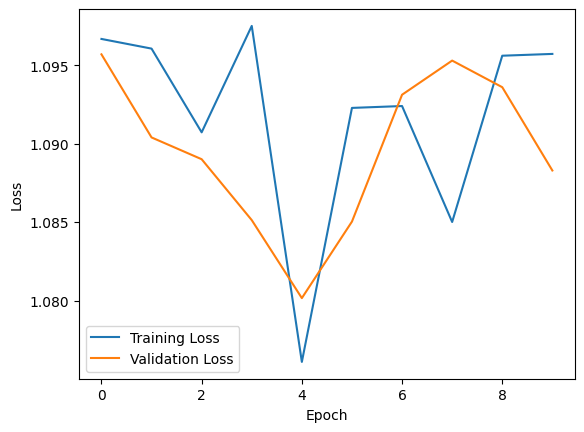

In [ ]:
# Train and validate the model
num_epochs = 10

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
  # Train
  model.train()
  train_loss = 0.0
  correct = 0
  total = 0
  for batch_num, (data, labels) in enumerate(train_loader):
    # print(f"batch number {batch_num}")
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  # Compute training accuracy and loss
  train_acc = 100 * correct / total
  train_loss /= len(train_loader)
  train_accs.append(train_acc)
  train_losses.append(train_loss)

  # Validate
  model.eval()
  val_loss = 0.0
  val_correct = 0
  val_total = 0
  with torch.no_grad():
    for val_data, val_labels in val_loader:
      val_outputs = model(val_data)
      val_loss += criterion(val_outputs, val_labels).item()
      _, val_predicted = torch.max(val_outputs.data, 1)
      val_total += val_labels.size(0)
      val_correct += (val_predicted == val_labels).sum().item()

  # Compute validation accuracy and loss
  val_acc = 100 * val_correct / val_total
  val_loss /= len(val_loader)
  val_accs.append(val_acc)
  val_losses.append(val_loss)

  print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

# Plot the loss functions
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for data, labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())



In [ ]:
# Evaluation metrics
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

confusion_mtx = confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### F1, Precision, Recall, Sensitivity, Specificity, TP, FP, TN, FN, plot and ROC curve and calculate AUC